<a href="https://colab.research.google.com/github/poojasaxena/tensorflow-developer-zertificate-coursera/blob/main/running_application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%autosave 30

Autosaving every 30 seconds


# Basics

## Import liberaries

In [87]:
import os
import sys
import string
import shutil
import logging
import random

import kaggle
import zipfile

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print(tf.__version__)
%matplotlib inline

2.6.0


## Setting up logger

In [5]:
def setup_logger(degree,enable=True):
    global logger
    logging.basicConfig(format='%(levelname)s:%(asctime)s: %(message)s',datefmt='%I:%M:%S %p',
                    level=degree)
    logger= logging.getLogger('test-logger')
    logger.disabled=False
    logger.info(f"logger {logger} has Disable::{logger.disabled}")

In [6]:
setup_logger(enable=True, degree=logging.INFO)

INFO:03:58:59 PM: logger <Logger test-logger (INFO)> has Disable::False


# Download Dataset from Kaggle

## in Google colab
* use this [reference](https://www.kaggle.com/general/74235)

In [7]:
#from google.colab import files
#files.upload()

In [8]:
 #! kaggle datasets list | grep 'cat'

In [9]:
#! kaggle competitions download -c "dogs-vs-cats"
#!kaggle competitions list -s health

## in Jupyter-notebook

In [10]:
base_dir = "/tmp/dogs_vs_cats/"

fresh_start = input("Do you want to fresh start with downloading dataset? reply 'yes' or 'no': ").upper()

if "YES" in fresh_start:
    if not os.path.exists(base_dir):
        logger.error(f"The path {base_dir} does not exist.")
    else:
        logger.warning(f'Clearning {base_dir}, as you asked for!')
        shutil.rmtree(base_dir)
        logger.info("You are ready for fresh start!!")
else:
    logger.info('Enjoy working non-fresh!')

Do you want to fresh start with downloading dataset? reply 'yes' or 'no': yes


INFO:03:59:06 PM: You are ready for fresh start!!


In [12]:
from kaggle.api.kaggle_api_extended import KaggleApi

def upload_kaggle_dataset(kaggle_dataset_name, base_dir_name):
    """
    kaggle_dataset_name: name of the dataset to be downloaded
    base_dir_name: some directory where it suppose to be downloaded
    """
    if os.path.exists(base_dir_name):
        logger.info(f"Dataset {kaggle_dataset_name} is avalable in {base_dir_name} with content: \n {os.listdir(base_dir_name)}")
        return
    else:
        logger.debug("Authenticating kaggle API======")
        api=KaggleApi()
        api.authenticate()
        api.competition_download_files(kaggle_dataset_name)
    
        logger.debug("Authenticated, downloading Dataset =======")
        with zipfile.ZipFile(kaggle_dataset_name+'.zip', mode='r') as zip_ref:
            zip_ref.extractall(base_dir_name)
            zip_ref.close()
        logger.info(f"Dataset {kaggle_dataset_name} is downloaded in {base_dir_name} with content: \n {os.listdir(base_dir_name)}")

In [13]:
## Lets download the kaggle dataset
kaggle_dataset_name = "dogs-vs-cats"
upload_kaggle_dataset(kaggle_dataset_name, base_dir_name=base_dir)

INFO:03:59:13 PM: Dataset dogs-vs-cats is downloaded in /tmp/dogs_vs_cats/ with content: 
 ['sampleSubmission.csv', 'test1.zip', 'train.zip']


In [ ]:
#upload_kaggle_dataset(kaggle_dataset_name="cat-breeds-dataset", base_dir_name="/tmp/cats")

# Preprocessing

## unzipping train/test dataset

In [14]:
## unzipped train/test directories
def unzip_sub_directories(train_zip_name, test_zip_name, base_dir_name): 
    
    ## Lets define our unzip directories names
    unzip_train_dir = os.path.join(base_dir_name, train_zip_name.split(".")[0])
    unzip_test_dir = os.path.join(base_dir_name, test_zip_name.split(".")[0])
    
    ## First checking it there are already unzipped directories existing 
    if os.path.exists(unzip_train_dir) and os.path.exists(unzip_test_dir):
        logger.warning(f'Unzipped directory of train/test exists in {base_dir_name}: \n {os.listdir(base_dir_name)}')
        return
    else:
        logger.info(f'Unzipping train/test directory in {base_dir_name} ======')

        ## Lets unzip the train/test zip files
        for zipped in [os.path.join(base_dir_name, train_zip_name), os.path.join(base_dir_name, test_zip_name)]:
            with zipfile.ZipFile(zipped, mode='r') as zip_ref:
                zip_ref.extractall(base_dir_name)
            zip_ref.close()
        
        logger.info(f'Finished, dataset exists in {base_dir_name} : \n {os.listdir(base_dir_name)}') 

In [15]:
## assign the train/test zip names 
sample,test_zip, train_zip = os.listdir(base_dir)

## unzip the train/test 
unzip_sub_directories(train_zip, test_zip, base_dir_name=base_dir)

INFO:03:59:30 PM: Unzipping train/test directory in /tmp/dogs_vs_cats/ ======
INFO:03:59:43 PM: Finished, dataset exists in /tmp/dogs_vs_cats/ : 
 ['sampleSubmission.csv', 'test1', 'test1.zip', 'train', 'train.zip']


## Check the unzipped data

In [16]:
sub_dir=["train", "test1"]
for sub in sub_dir:
    useful_files_in_train = [f for f in os.listdir(os.path.join(base_dir, sub)) if f.startswith('cat') or f.startswith("dog")]
    print(f"There are {len(useful_files_in_train)} images in {os.path.join(base_dir, sub)}")

There are 25000 images in /tmp/dogs_vs_cats/train
There are 0 images in /tmp/dogs_vs_cats/test1


## Create directory structure
- As there is none dog/cat labeled data in `/tmp/dogs_vs_cats/test1` folder, we will create `test` directory and create train/test/validation directories structures
- directory structure : `/tmp/dogs_vs_cats/train/cat&dog` vs `/tmp/dogs_vs_cat/validation/cat&do` `/tmp/dogs_vs_cat/test/cat&dog`

In [98]:
train_eval_dirs = ["train/cat", 'train/dog', 'eval/cat',  'eval/dog', 'test/cat', 'test/dog']

# base directories, in order for them to feed to Image_data_generator for preprocessing before feeding to CNN
base_train = os.path.join(base_dir, "train")
base_eval = os.path.join(base_dir, "eval")
base_test = os.path.join(base_dir, "test")

## train
base_train_cat = os.path.join(base_dir, train_eval_dirs[0])
base_train_dog = os.path.join(base_dir, train_eval_dirs[1])

## evaluate
base_eval_cat = os.path.join(base_dir, train_eval_dirs[2])
base_eval_dog = os.path.join(base_dir, train_eval_dirs[3])

## test
base_test_cat = os.path.join(base_dir, train_eval_dirs[4])
base_test_dog = os.path.join(base_dir, train_eval_dirs[5])


for dirs in train_eval_dirs:
    if not os.path.exists(os.path.join(base_dir, dirs)):
        os.makedirs(os.path.join(base_dir, dirs))
    else:
        print(f'The directories {dirs} exists already.')

The directories train/cat exists already.
The directories train/dog exists already.
The directories eval/cat exists already.
The directories eval/dog exists already.
The directories test/cat exists already.
The directories test/dog exists already.


## Seperate dog/cat data
- since all the data & cat dataset is in `/tmp/dogs_vs_dats/train` 
- we will seperate them it to `/tmp/dogs_vs_dats/train/dogs` and `/tmp/dogs_vs_cats/train/cats` 

In [61]:
def move_to_destination(origin, destination, image_name, split_dataset_percentage):

    ## first check if the origin directory exists
    if not os.path.exists(origin):
        logger.error(f"The path {origin} does not exist, existing.")
        return
    
    ## lets check if there is any data in origin to copy to destination
    elif len(os.listdir(origin))<=5:
        fname_dir=[file for file in os.listdir(origin) if os.path.isdir(os.path.join(origin,file))]
        fname_files=[file for file in os.listdir(origin) if os.path.isfile(os.path.join(origin,file))]
        logger.warning(f"There are {len(fname_dir)} {fname_dir} directory & {len(fname_files)} image dataset in {origin} to copy.")
        
        if len(os.listdir(destination))>0:
            logger.info(f"There is already {len(os.listdir(destination))} image dataset in {destination}.")
            return
        return
    else:
        ## Lets move the image dataset
        num_images = [f for f in os.listdir(origin) if f.endswith('jpg') & f.startswith(image_name)]
        logger.info(f"Out of {len(num_images)} {image_name} images in {origin}, {int(len(num_images)*float(split_dataset_percentage))} will be moved to {destination}")
    
        random_images = random.sample(num_images, int(len(num_images)*split_dataset_percentage))
        for image in random_images:      
            logger.debug(origin+'/'+image, destination+'/'+image)
            os.replace(origin+'/'+image, destination+'/'+image) 
            continue
        
        logger.info(f'    ====== Finished moving the file. There are {len(os.listdir(destination))} {image_name} examples in {destination}')

In [58]:
## Lets first move all data to base_train_cat, base_train_dog
origin_dir = os.path.join(base_dir, "train")
move_to_destination(origin=origin_dir, destination=base_train_cat, image_name="cat", split_dataset_percentage=1)
move_to_destination(origin=origin_dir, destination=base_train_dog, image_name="dog", split_dataset_percentage=1)

INFO:09:20:25 AM: There is already 12500 image dataset in /tmp/dogs_vs_cats/train/cat.
INFO:09:20:25 AM: There is already 12500 image dataset in /tmp/dogs_vs_cats/train/dog.


## Prepare validation/test dataset
- We will use the above function to prepare our test/validation dataset
- since all the dataset is in train, we will move 10% into test and 10% into validation

In [60]:
move_to_destination(origin=base_train_cat, destination=base_test_cat, image_name="cat",split_dataset_percentage=0.1)
move_to_destination(origin=base_train_dog, destination=base_test_dog, image_name="dog",split_dataset_percentage=0.1)
move_to_destination(origin=base_train_cat, destination=base_eval_cat, image_name="cat",split_dataset_percentage=0.1)
move_to_destination(origin=base_train_dog, destination=base_eval_dog, image_name="dog",split_dataset_percentage=0.1)

INFO:09:24:24 AM: Out of 12500 cat images in /tmp/dogs_vs_cats/train/cat, 1250 will be moved to /tmp/dogs_vs_cats/test/cat
INFO:09:24:25 AM: Finished moving the file. There are 1250 cat examples in /tmp/dogs_vs_cats/test/cat
INFO:09:24:25 AM: Out of 12500 dog images in /tmp/dogs_vs_cats/train/dog, 1250 will be moved to /tmp/dogs_vs_cats/test/dog
INFO:09:24:27 AM: Finished moving the file. There are 1250 dog examples in /tmp/dogs_vs_cats/test/dog
INFO:09:24:27 AM: Out of 11250 cat images in /tmp/dogs_vs_cats/train/cat, 1125 will be moved to /tmp/dogs_vs_cats/eval/cat
INFO:09:24:28 AM: Finished moving the file. There are 1125 cat examples in /tmp/dogs_vs_cats/eval/cat
INFO:09:24:28 AM: Out of 11250 dog images in /tmp/dogs_vs_cats/train/dog, 1125 will be moved to /tmp/dogs_vs_cats/eval/dog
INFO:09:24:28 AM: Finished moving the file. There are 1125 dog examples in /tmp/dogs_vs_cats/eval/dog


## Image Visualization

In [62]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

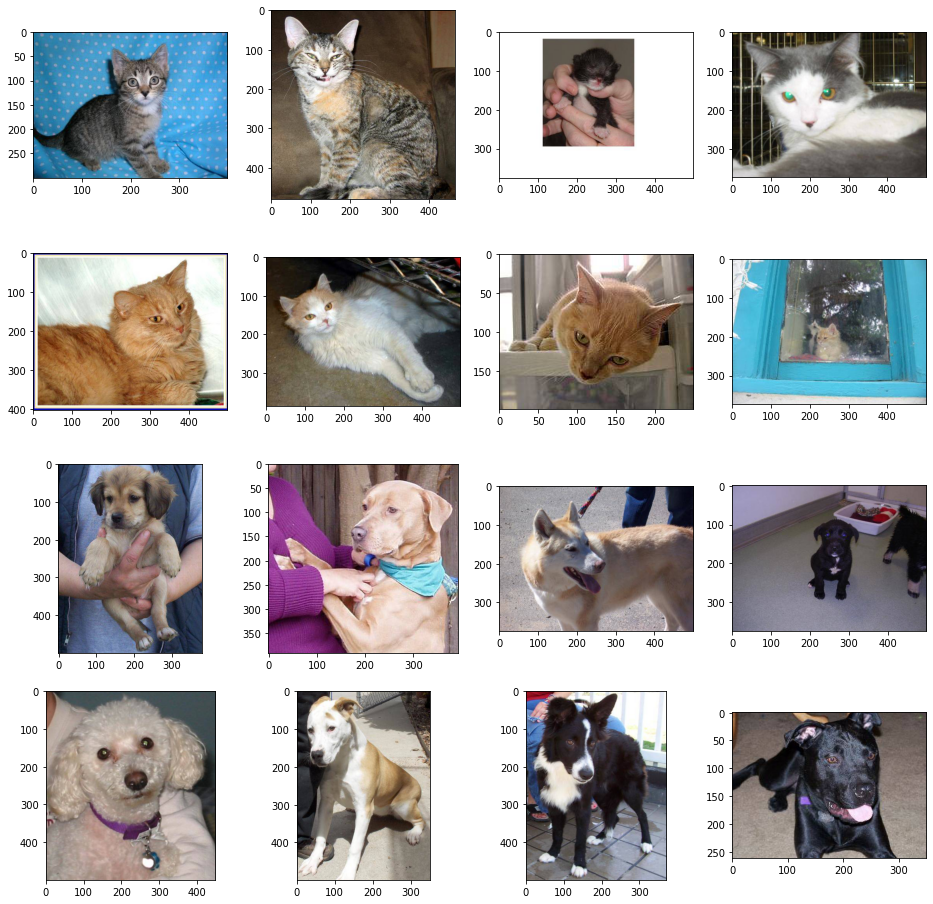

In [64]:
pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8
next_cat_pix = [os.path.join(base_train_cat, fname) 
                for fname in os.listdir(base_train_cat)[ pic_index-8:pic_index]]

next_dog_pix = [os.path.join(base_train_dog, fname) 
                for fname in os.listdir(base_train_dog)[ pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
      #sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

# Modeling

In [67]:
from tensorflow.keras import layers, models, optimizers

def create_model(activation_function):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        layers.MaxPool2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPool2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPool2D((2,2)),
        
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPool2D((2,2)),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation=activation_function)        
    ])
    
    if activation_function=="sigmoid":
        loss_function = 'binary_crossentropy'
        metric_function="accuracy"
    elif activation_function == "softmax":
        loss_function = "sparse_categorical_crossentropy"
        metric_function = "sparse_categorical_accuracy"
    else:
        logger.warning(f"Given {activation_function} is not defined, loss_function and metrics are not known.")
        
    # compile the model
    model.compile(
        optimizer=optimizers.Adam(),
        loss=loss_function,
        metrics =[metric_function]
    )
    
    return model

In [75]:
cnn_model=create_model(activation_function="sigmoid")
cnn_model.summary()

## Data Preparation
Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit`, `evaluate_generator`, and `predict_generator`.

In [72]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(base_train,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(base_eval,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 20250 images belonging to 2 classes.
Found 2250 images belonging to 2 classes.


In [73]:
print(f"labels for each class in the train generator are: {train_generator.class_indices}")
print(f"labels for each class in the validation generator are: {validation_generator.class_indices}")

labels for each class in the train generator are: {'cat': 0, 'dog': 1}
labels for each class in the validation generator are: {'cat': 0, 'dog': 1}


## Model fitting

In [76]:
history_cnn = cnn_model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_steps=50,
                              verbose=2)

2021-09-29 09:58:12.931657: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
100/100 - 22s - loss: 0.6999 - accuracy: 0.5045 - val_loss: 0.6900 - val_accuracy: 0.5790
Epoch 2/50
100/100 - 21s - loss: 0.6933 - accuracy: 0.5350 - val_loss: 0.6854 - val_accuracy: 0.5300
Epoch 3/50
100/100 - 23s - loss: 0.6868 - accuracy: 0.5390 - val_loss: 0.6879 - val_accuracy: 0.5660
Epoch 4/50
100/100 - 24s - loss: 0.6915 - accuracy: 0.5265 - val_loss: 0.6905 - val_accuracy: 0.5390
Epoch 5/50
100/100 - 22s - loss: 0.6695 - accuracy: 0.5795 - val_loss: 0.6828 - val_accuracy: 0.5740
Epoch 6/50
100/100 - 25s - loss: 0.6755 - accuracy: 0.5890 - val_loss: 0.6475 - val_accuracy: 0.6410
Epoch 7/50
100/100 - 23s - loss: 0.6654 - accuracy: 0.6050 - val_loss: 0.6538 - val_accuracy: 0.6280
Epoch 8/50
100/100 - 23s - loss: 0.6446 - accuracy: 0.6455 - val_loss: 0.6252 - val_accuracy: 0.6690
Epoch 9/50
100/100 - 22s - loss: 0.6060 - accuracy: 0.6750 - val_loss: 0.6252 - val_accuracy: 0.6770
Epoch 10/50
100/100 - 24s - loss: 0.5957 - accuracy: 0.6930 - val_loss: 0.5906 - val_accura

# Evaluating model

## Plotting accuracy/loss 

In [78]:
sys.path.append("/Users/psaxena/Documents/weitebildung/tensorflow-developer-zertificate-coursera/pool_common_scripts")

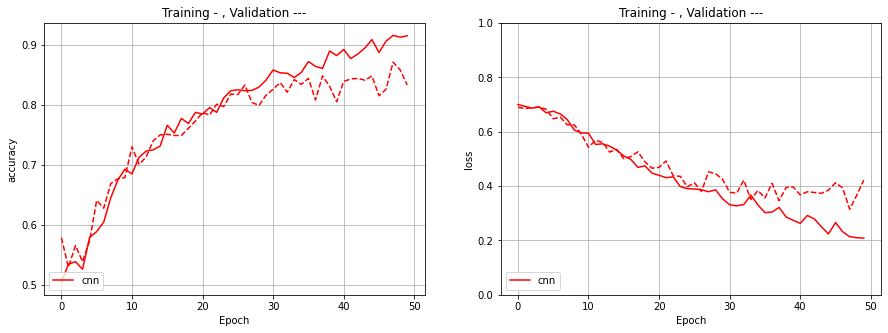

In [81]:
from ploting_script import plot_n_model
plot_n_model(num_history=1, name_history=[history_cnn], label_list=["cnn"], ylim_low=0)

## prediction on test

In [111]:
# Use the validation generator without shuffle to easily compute additional metrics
test_gen_no_shuffle = test_datagen.flow_from_directory(
    base_test,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)
print(f"labels for each class in the test generator are: {test_gen_no_shuffle.class_indices}")

Found 2500 images belonging to 2 classes.
labels for each class in the test generator are: {'cat': 0, 'dog': 1}


In [131]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

# Get the true labels from the generator
y_true = test_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions_balanced = cnn_model.predict(test_gen_no_shuffle)

y_pred_balanced = np.where(predictions_balanced < 0.5, 0 , 1)

# Get the argmax (since softmax is being used)
#y_pred_balanced = np.argmax(predictions_balanced, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_balanced)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score of balanced dataset: {balanced_accuracy_score(y_true, y_pred_balanced)}")

Accuracy Score: 0.8248
Balanced Accuracy Score of balanced dataset: 0.8248


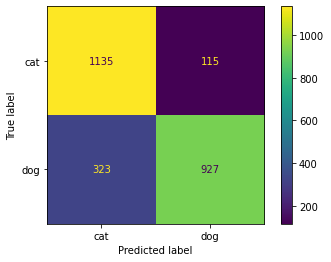

In [132]:
imbalanced_cm = confusion_matrix(y_true, y_pred_balanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['cat', 'dog']).plot(values_format='d')

## External image prediction

In [88]:
from keras.models import load_model
from keras.preprocessing import image

def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [133]:
def predict_new_image(model, image_name):
    
    # image path
    img_path = 'test_images/' + image_name

    if not os.path.exists(img_path):
        logger.error(f"{img_path} does not exist")
        return
    
    # load a single image
    new_image = load_image(img_path, show=True)
    pred = model.predict(new_image)
    
    if pred[0]>0.5:
        print(pred[0], " is a dog")    
    else:
        print(pred[0], " is a cat")

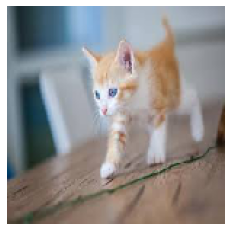

[0.05738512]  is a cat


In [141]:
predict_new_image(model=cnn_model, image_name="cat_04.jpeg")

In [ ]:
## Testing on uploaded images
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

# Visualizing intermediate Representation

In [ ]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(base_train_cat, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(base_train_dog, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

# Saving the model

## json and h5

In [148]:
path_to_save_model="/Users/psaxena/Documents/work_mode/ml_in_produdction/model/"

model_json = cnn_model.to_json()
with open(path_to_save_model+"model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
cnn_model.save_weights("model.h5")
cnn_model.save_weights(path_to_save_model+"model.h5")

## saving history

In [149]:
## saving history
try:
    import dill as pickle
except ImportError:
    import pickle
with open(path_to_save_model+'history_CNN_Dict','wb') as file_pi:
    pickle.dump(history_cnn.history, file_pi)

# Cleanup

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

# Tasklist
- make moving --- with time while running code
- ~~save model as h5 and history too~~
- improve the model architecture
-  ~~setup tain/test/validation dataset~~
- improve predictiom function
- setup online application
- rebuild Tensorflow
```
2021-09-29 09:45:43.659538: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Out[69]:
```
- imporove saving model function


